# Neural Network for Time-Stepping Prediction of Buildings

In [1]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy import signal
import timeit

import matplotlib.pyplot as plt
import pandas as pd
import random
from sklearn.metrics import r2_score

from sklearn.preprocessing import StandardScaler

from tradnet_regression import *

## Set Inputs

In [2]:
seed = 7
n_samples = 10000
num_metaims = 5             # NOTE: Here this variable denotes the number of Intensity Measures to use

In [3]:
path_to_predictor_dataset = 'predictors_new.parquet'           # Set the path to your analysis data file (csv/parquet)
path_to_pga_dataset = '../../RC_Frame_large/pga_all_new.parquet'

## Read Inputs

In [4]:
cols2read = ['storeys', 'bays', 'storey_ht', 'bay_width', 'w_floor', 
             'f_c', 'gm_index', 'pga', 'pgv', 'drift_ratio_pct_max', 'damage_state']

predictors_all = pd.read_parquet(path_to_predictor_dataset, columns = cols2read, engine = 'pyarrow')
# Eliminate Outliers
predictors_all = predictors_all[predictors_all['drift_ratio_pct_max']<20].reset_index(drop = True)

predictors_all['building_ht'] = predictors_all['storeys'] * predictors_all['storey_ht']
predictors_all['building_width'] = predictors_all['bays'] * predictors_all['bay_width']

In [5]:
pga_all = pd.read_parquet(path_to_pga_dataset, engine = 'pyarrow')
# predictors_all = predictors_all.merge(pga_all[['sa01', 'sa02', 'sa03', 'sa06', 'sa10', 'sa20', 'arias', 'sed', 'cav', 'ASI_05', 'ASI_10']], 
#                                       left_on = 'gm_index', right_index = True)

We assume the collapse capacity of the building to be 12 inches

In [6]:
# capacity = 12
# predictors_all['capacity'] = capacity
# predictors_all['damage_state'] = 0

# predictors_all.loc[predictors_all['tip_displacement']>predictors_all['capacity'], 'damage_state'] = 1

# predictors_all = predictors_all.drop(columns = ['storeys', 'storey_ht', 'bays', 'bay_width', 'capacity'])

## Auto-Encoder-Decoder Network to Extract Meta-IMs

In [7]:
# Define the Autoencoder model using PyTorch
class Autoencoder(nn.Module):
    def __init__(self, input_size, reduced_size, hidden_size):
        super(Autoencoder, self).__init__()
        activation = nn.ELU
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),  # Encoder layer
            activation(),
            nn.Linear(hidden_size, hidden_size),  # Encoder layer
            activation(),
            nn.Linear(hidden_size, hidden_size),  # Encoder layer
            activation(),
            nn.Linear(hidden_size, hidden_size),  # Encoder layer
            activation(),
            nn.Linear(hidden_size, hidden_size),  # Encoder layer
            activation(),            
            nn.Linear(hidden_size, reduced_size),  # Encoder layer
            # activation()
        )
        self.decoder = nn.Sequential(
            nn.Linear(reduced_size, hidden_size),  # Encoder layer
            activation(),
            nn.Linear(hidden_size, hidden_size),  # Encoder layer
            activation(),
            nn.Linear(hidden_size, hidden_size),  # Encoder layer
            activation(),
            nn.Linear(hidden_size, hidden_size),  # Encoder layer
            activation(),
            nn.Linear(hidden_size, hidden_size),  # Encoder layer
            activation(),
            nn.Linear(hidden_size, input_size),  # Decoder layer
            # activation()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
def get_gm_tensors(train_data, val_data, test_data):
    gm_sequence_train = np.sort(train_data['gm_index'].unique())
    gm_sequence_train_df = pd.DataFrame(gm_sequence_train, columns = ['gm_index_old'])
    gm_sequence_train_df['gm_ind_new'] = gm_sequence_train_df.index
    train_data = pd.merge(train_data, gm_sequence_train_df, left_on = 'gm_index', right_on = 'gm_index_old')
    
    gm_sequence_val = np.sort(val_data['gm_index'].unique())
    gm_sequence_val_df = pd.DataFrame(gm_sequence_val, columns = ['gm_index_old'])
    gm_sequence_val_df['gm_ind_new'] = gm_sequence_val_df.index
    val_data = pd.merge(val_data, gm_sequence_val_df, left_on = 'gm_index', right_on = 'gm_index_old')
    
    gm_sequence_test = np.sort(test_data['gm_index'].unique())
    gm_sequence_test_df = pd.DataFrame(gm_sequence_test, columns = ['gm_index_old'])
    gm_sequence_test_df['gm_ind_new'] = gm_sequence_test_df.index
    test_data = pd.merge(test_data, gm_sequence_test_df, left_on = 'gm_index', right_on = 'gm_index_old')
    
    # Load the ground motions
    x_th_all = torch.load('../../RC_Frame_large/x_gm')
    x_th_all = torch.tensor(x_th_all, dtype=torch.float32)
    
    x_th = x_th_all[gm_sequence_train, :]
    x_th_val = x_th_all[gm_sequence_val, :]
    x_th_test = x_th_all[gm_sequence_test, :]
    
    return x_th, x_th_val, x_th_test, train_data, val_data, test_data

def train_AED_gm_features(x_th, reduced_size = 5, hidden_size = 256, num_epochs = 1000):
    autoencoder = Autoencoder(input_size = x_th.shape[1], 
                              reduced_size = reduced_size, 
                              hidden_size = hidden_size)

    # Define the loss function and optimizer for the autoencoder
    criterion = nn.MSELoss()
    autoencoder_optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

    # Train the Autoencoder
    start = timeit.default_timer()
    for epoch in range(num_epochs):

        inputs = x_th
        autoencoder_optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        autoencoder_optimizer.step()
        if (epoch+1) % 50 != 0:
            continue
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.6f}')

    stop = timeit.default_timer()
    
    print('Time Elapsed in AED Training: ', stop - start)
    
    return autoencoder


def extract_gm_features(autoencoder, x_th):
    # Extract encoded features
    encoded_features = autoencoder.encoder(x_th).detach()
    
    n_features = encoded_features.shape[1]
    
    pca_df = pd.DataFrame(encoded_features, 
                          columns = ['encoded_{}'.format(i+1) for i in range(n_features)])
    pca_df['gm_index'] = pca_df.index
    
    return pca_df

def get_features_AED(train_data, val_data, test_data, reduced_size = 5):
    x_th, x_th_val, x_th_test, train_data, val_data, test_data = get_gm_tensors(train_data, 
                                                                                val_data, 
                                                                                test_data)
    
    autoencoder = train_AED_gm_features(x_th, 
                                        reduced_size, 
                                        hidden_size = 256, 
                                        num_epochs = 1000)
    
    pca_df_train = extract_gm_features(autoencoder, x_th)
    pca_df_val = extract_gm_features(autoencoder, x_th_val)
    pca_df_test = extract_gm_features(autoencoder, x_th_test)
    
    train_data = pd.merge(train_data, pca_df_train, left_on = 'gm_ind_new', right_on = 'gm_index')
    val_data = pd.merge(val_data, pca_df_val, left_on = 'gm_ind_new', right_on = 'gm_index')
    test_data = pd.merge(test_data, pca_df_test, left_on = 'gm_ind_new', right_on = 'gm_index')
        
    return train_data, val_data, test_data

## Prepare training data

In [8]:
train_data, val_data, test_data = create_train_val_test_splits(predictors_all, 
                                                               n_samples = n_samples, 
                                                               split_frac = 0.9, 
                                                               random_seed = seed)

# Extract GM features
train_data, val_data, test_data = get_features_AED(train_data, 
                                                   val_data, 
                                                   test_data, 
                                                   reduced_size = num_metaims)

cols2scale = ['building_ht', 'building_width', 'w_floor', 'f_c']
cols_predicted = ['damage_state']

cols_gm = ['encoded_{}'.format(i+1) for i in range(num_metaims)]

x_data, x_val, x_test, y_data, y_val, y_test = create_scaled_inputs_outputs(train_data, 
                                                                            val_data, 
                                                                            test_data, 
                                                                            cols2scale, 
                                                                            cols_gm)


/tmp/ipykernel_36452/584570502.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_th_all = torch.tensor(x_th_all, dtype=torch.float32)


Epoch [50/1000], Loss: 0.004952
Epoch [100/1000], Loss: 0.004450
Epoch [150/1000], Loss: 0.003750
Epoch [200/1000], Loss: 0.003151
Epoch [250/1000], Loss: 0.002642
Epoch [300/1000], Loss: 0.002034
Epoch [350/1000], Loss: 0.001414
Epoch [400/1000], Loss: 0.000940
Epoch [450/1000], Loss: 0.000655
Epoch [500/1000], Loss: 0.000389
Epoch [550/1000], Loss: 0.000205
Epoch [600/1000], Loss: 0.000106
Epoch [650/1000], Loss: 0.000086
Epoch [700/1000], Loss: 0.000095
Epoch [750/1000], Loss: 0.000045
Epoch [800/1000], Loss: 0.000033
Epoch [850/1000], Loss: 0.000032
Epoch [900/1000], Loss: 0.000021
Epoch [950/1000], Loss: 0.000012
Epoch [1000/1000], Loss: 0.000008
Time Elapsed in AED Training:  2270.798524830956


## Train TradNet Model

In [32]:
max_epochs = 5000
interval = 500

start = timeit.default_timer()
model, error_evolution_training, error_evolution_val = train_tradnet_model(x_data, 
                                                                      x_val, 
                                                                      y_data, 
                                                                      y_val, 
                                                                      train_data, 
                                                                      val_data,
                                                                      max_epochs = max_epochs,
                                                                      interval = interval)
stop = timeit.default_timer()

Epoch 1: Training RMSE Loss 4.3248, Validation RMSE Loss 4.3622
Epoch 500: Training RMSE Loss 3.1429, Validation RMSE Loss 3.1557
Epoch 1000: Training RMSE Loss 2.2011, Validation RMSE Loss 2.1712
Epoch 1500: Training RMSE Loss 1.5053, Validation RMSE Loss 1.5475
Epoch 2000: Training RMSE Loss 1.3219, Validation RMSE Loss 1.4496
Epoch 2500: Training RMSE Loss 1.2266, Validation RMSE Loss 1.4116
Epoch 3000: Training RMSE Loss 1.1760, Validation RMSE Loss 1.3800
Epoch 3500: Training RMSE Loss 1.1484, Validation RMSE Loss 1.3723
Epoch 4000: Training RMSE Loss 1.1267, Validation RMSE Loss 1.3706
Epoch 4500: Training RMSE Loss 1.1022, Validation RMSE Loss 1.3661
Epoch 5000: Training RMSE Loss 1.0766, Validation RMSE Loss 1.3471


In [33]:
print('Time Elapsed in Model Training: ', stop - start)

Time Elapsed in Model Training:  20.57330779125914


In [34]:
y_pred_val = predict_tradnet(model, x_val)
val_data['drift_ratio_pred'] = y_pred_val.detach().view(-1).numpy()

y_pred_train = predict_tradnet(model, x_data)
train_data['drift_ratio_pred'] = y_pred_train.detach().view(-1).numpy()

## True v/s Predicted Response on Training Data

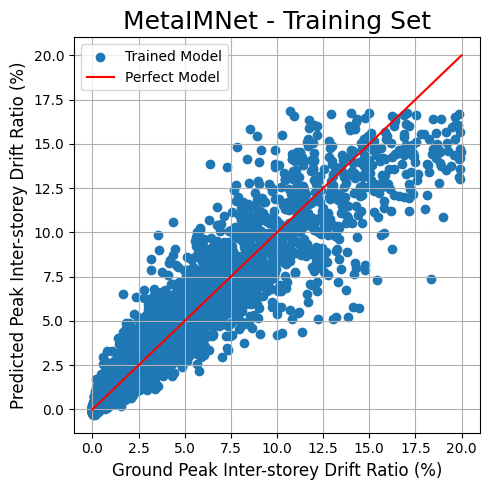

RMSE = 1.077, R2 = 0.889


In [35]:
plot_scatter_results(train_data, 'MetaIMNet - Training Set')

## Loss Evolution

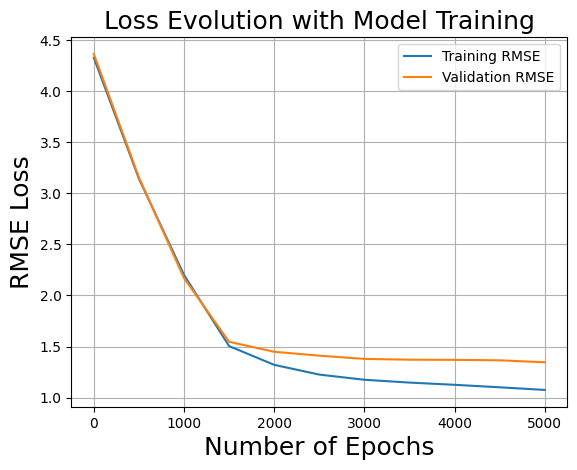

In [36]:
# Loss evolution curve
fig, ax = plt.subplots(1,1)
ax.plot(range(0, interval + max_epochs, interval), error_evolution_training, label = 'Training RMSE')
ax.plot(range(0, interval + max_epochs, interval), error_evolution_val, label = 'Validation RMSE')
# ax.set(title="Loss Evolution with Model Training", xlabel="Number of Epochs", ylabel="MSE Loss")
ax.set_title("Loss Evolution with Model Training", fontsize = 18)
ax.set_xlabel("Number of Epochs", fontsize = 18)
ax.set_ylabel("RMSE Loss", fontsize = 18)
ax.legend()
ax.grid()
plt.show()

## Make Predictions on Test Data

In [37]:
y_pred_test = predict_tradnet(model, x_test)
test_data['drift_ratio_pred'] = y_pred_test.detach().view(-1).numpy()

## True v/s Predicted Response on Test Data

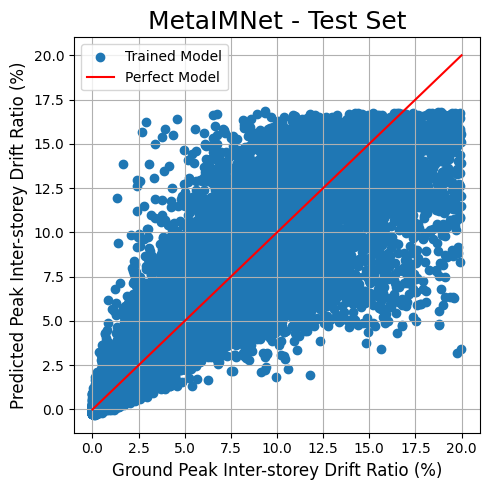

RMSE = 1.296, R2 = 0.837


In [38]:
plot_scatter_results(test_data, 'MetaIMNet - Test Set')

## True v/s Predicted Response on Combined Train, Validation, and Test Data

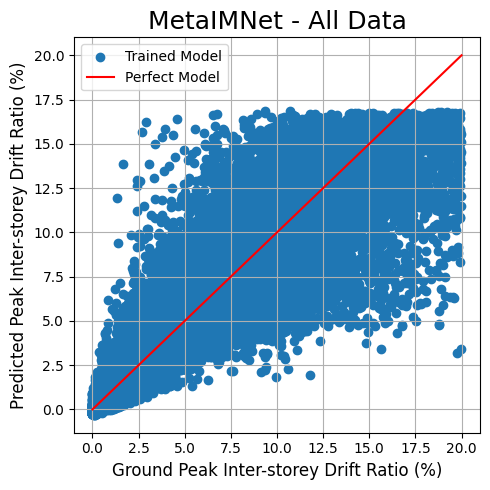

RMSE = 1.275, R2 = 0.842


In [39]:
all_data = pd.concat([train_data, val_data, test_data]).reset_index(drop = True)
plot_scatter_results(all_data, 'MetaIMNet - All Data')

In [40]:
# all_data.to_parquet('all_data_drift_tradaed_reg.parquet', engine = 'pyarrow')

In [41]:
# test_data.to_parquet('test_data_drift_tradaed_reg.parquet', engine = 'pyarrow')